<a href="https://colab.research.google.com/github/MarriRohan/Reinforcement-Learning-2025/blob/main/Lab%2010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Collected 14695 steps from expert. Expert success episodes: 300/300
Training behavioral cloning policy (supervised)...
Epoch 1/20  Loss: 0.4334  Train-Acc: 0.861
Epoch 2/20  Loss: 0.2396  Train-Acc: 0.929
Epoch 3/20  Loss: 0.1905  Train-Acc: 0.944
Epoch 4/20  Loss: 0.1546  Train-Acc: 0.955
Epoch 5/20  Loss: 0.1303  Train-Acc: 0.962
Epoch 6/20  Loss: 0.1240  Train-Acc: 0.964
Epoch 7/20  Loss: 0.1129  Train-Acc: 0.966
Epoch 8/20  Loss: 0.1046  Train-Acc: 0.968
Epoch 9/20  Loss: 0.1044  Train-Acc: 0.968
Epoch 10/20  Loss: 0.1012  Train-Acc: 0.970
Epoch 11/20  Loss: 0.0979  Train-Acc: 0.970
Epoch 12/20  Loss: 0.0945  Train-Acc: 0.970
Epoch 13/20  Loss: 0.0919  Train-Acc: 0.971
Epoch 14/20  Loss: 0.0928  Train-Acc: 0.970
Epoch 15/20  Loss: 0.0925  Train-Acc: 0.971
Epoch 16/20  Loss: 0.0878  Train-Acc: 0.972
Epoch 17/20  Loss: 0.0872  Train-Acc: 0.973
Epoch 18/20  Loss: 0.0886  Train-Acc: 0.973
Epoch 19/20  Loss: 0.0887  Train-Acc: 0.971
Epoch 20/20  Loss: 0.0781  Train-Acc: 0.974
Evaluating

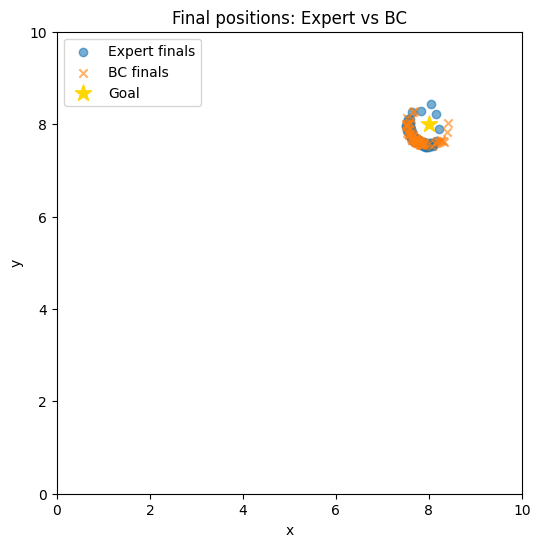

In [ ]:
"""
behavioral_cloning_tank.py

Single-file demo:
 - Simple TankEnv (gym-like)
 - Expert policy that drives the tank to a goal
 - Collect expert dataset
 - Train a PyTorch policy network via Behavioral Cloning
 - Evaluate and compare expert vs cloned policy

Run:
    python behavioral_cloning_tank.py
"""

import math
import random
from collections import deque
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# -------------------------
# 1) Simple Tank Environment
# -------------------------
class TankEnv:
    """
    Minimal gym-like environment for a 2D tank that must reach a fixed goal.
    State: [x, y, cos(theta), sin(theta), vx, vy]  (continuous)
    Action (discrete, 3): 0 = turn left & forward, 1 = forward, 2 = turn right & forward
    """

    def __init__(self, dt=0.1, max_steps=200, arena_size=10.0, goal=(8.0, 8.0), seed=None):
        self.dt = dt
        self.max_steps = max_steps
        self.arena_size = arena_size
        self.goal = np.array(goal, dtype=np.float32)
        self.rng = np.random.RandomState(seed)
        self.reset()

    def reset(self, start_state=None):
        # Random start if not provided
        if start_state is None:
            x = self.rng.uniform(1.0, self.arena_size - 1.0)
            y = self.rng.uniform(1.0, self.arena_size - 1.0)
            theta = self.rng.uniform(-math.pi, math.pi)
        else:
            x, y, theta = start_state
        self.pos = np.array([x, y], dtype=np.float32)
        self.theta = float(theta)
        self.speed = 1.0  # constant forward speed
        self.step_count = 0
        obs = self._get_obs()
        return obs

    def _get_obs(self):
        # Observation: x, y, cos(theta), sin(theta), vx, vy, goal_x, goal_y
        vx = self.speed * math.cos(self.theta)
        vy = self.speed * math.sin(self.theta)
        obs = np.array([self.pos[0], self.pos[1],
                        math.cos(self.theta), math.sin(self.theta),
                        vx, vy, self.goal[0], self.goal[1]], dtype=np.float32)
        return obs

    def step(self, action):
        # actions: 0 left, 1 straight, 2 right
        turn_rate = 0.25  # radian per step
        if action == 0:
            self.theta += turn_rate
        elif action == 2:
            self.theta -= turn_rate
        # move forward
        self.pos[0] += self.speed * math.cos(self.theta) * self.dt
        self.pos[1] += self.speed * math.sin(self.theta) * self.dt

        # keep inside arena
        self.pos = np.clip(self.pos, 0.0, self.arena_size)
        self.step_count += 1

        # reward and done (only for evaluation, BC doesn't use reward)
        dist_to_goal = np.linalg.norm(self.pos - self.goal)
        done = (dist_to_goal < 0.5) or (self.step_count >= self.max_steps)
        reward = -dist_to_goal
        obs = self._get_obs()
        info = {"dist": float(dist_to_goal)}
        return obs, reward, done, info

# -------------------------
# 2) Expert policy
# -------------------------
def expert_policy(obs):
    """
    Simple reactive expert:
      - compute angle to goal
      - if angle difference > +eps => turn left
      - if angle difference < -eps => turn right
      - else go straight
    """
    x, y, cos_t, sin_t, vx, vy, gx, gy = obs
    theta = math.atan2(sin_t, cos_t)
    vec_goal = np.array([gx - x, gy - y], dtype=np.float32)
    desired_theta = math.atan2(vec_goal[1], vec_goal[0])
    diff = (desired_theta - theta + math.pi) % (2 * math.pi) - math.pi
    eps = 0.2  # tolerance radians
    if diff > eps:
        return 0  # turn left
    elif diff < -eps:
        return 2  # turn right
    else:
        return 1  # straight

# -------------------------
# 3) Dataset utilities
# -------------------------
class ExpertDataset(Dataset):
    def __init__(self, observations, actions):
        self.obs = np.array(observations, dtype=np.float32)
        self.acts = np.array(actions, dtype=np.int64)

    def __len__(self):
        return len(self.acts)

    def __getitem__(self, idx):
        return self.obs[idx], self.acts[idx]

# -------------------------
# 4) Policy network (PyTorch)
# -------------------------
class PolicyNet(nn.Module):
    def __init__(self, input_dim, hidden=128, n_actions=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_actions)
        )

    def forward(self, x):
        return self.net(x)

# -------------------------
# 5) Data collection (expert)
# -------------------------
def collect_expert_data(env, n_episodes=200, max_steps_per_ep=200, deterministic=True):
    observations = []
    actions = []
    success = 0
    for ep in range(n_episodes):
        obs = env.reset()
        for t in range(max_steps_per_ep):
            a = expert_policy(obs)
            observations.append(obs.copy())
            actions.append(a)
            obs, r, done, info = env.step(a)
            if done:
                if info["dist"] < 0.5:
                    success += 1
                break
    return observations, actions, success

# -------------------------
# 6) Training loop for BC
# -------------------------
def train_behavioral_cloning(dataset, input_dim, n_actions, epochs=10, batch_size=64, lr=1e-3, device='cpu'):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = PolicyNet(input_dim, hidden=128, n_actions=n_actions).to(device)
    criterion = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=lr)

    for ep in range(epochs):
        model.train()
        total_loss = 0.0
        total = 0
        correct = 0
        for obs_batch, act_batch in loader:
            obs_batch = obs_batch.to(device)
            act_batch = act_batch.to(device)
            logits = model(obs_batch)
            loss = criterion(logits, act_batch)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item() * obs_batch.size(0)
            total += obs_batch.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == act_batch).sum().item()
        acc = correct / total
        print(f"Epoch {ep+1}/{epochs}  Loss: {total_loss/total:.4f}  Train-Acc: {acc:.3f}")
    return model

# -------------------------
# 7) Evaluation
# -------------------------
def evaluate_policy(env, policy_fn, n_episodes=50, max_steps=200):
    dists = []
    successes = 0
    for _ in range(n_episodes):
        obs = env.reset()
        for t in range(max_steps):
            a = policy_fn(obs)
            obs, r, done, info = env.step(a)
            if done:
                dists.append(info['dist'])
                if info['dist'] < 0.5:
                    successes += 1
                break
    avg_dist = np.mean(dists) if len(dists) > 0 else float('nan')
    return avg_dist, successes

# wrapper to use a trained model
def make_model_policy(model, device='cpu'):
    def policy(obs):
        model.eval()
        x = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = model(x)
            action = int(logits.argmax(dim=1).item())
        return action
    return policy

# -------------------------
# 8) Main flow
# -------------------------
def main():
    # configuration
    seed = 42
    env = TankEnv(seed=seed)
    np.random.seed(seed)
    random.seed(seed)

    print("Collecting expert demonstrations...")
    obs, acts, expert_success = collect_expert_data(env, n_episodes=300)
    print(f"Collected {len(acts)} steps from expert. Expert success episodes: {expert_success}/300")

    dataset = ExpertDataset(obs, acts)
    input_dim = dataset.obs.shape[1]
    n_actions = 3

    print("Training behavioral cloning policy (supervised)...")
    device = 'cpu'
    model = train_behavioral_cloning(dataset, input_dim, n_actions, epochs=20, batch_size=64, lr=1e-3, device=device)

    # make policy functions
    expert_policy_fn = expert_policy
    bc_policy_fn = make_model_policy(model, device=device)

    # Evaluate expert on new episodes
    print("Evaluating expert on 100 episodes...")
    env_eval = TankEnv(seed=1234)
    expert_avg_dist, expert_successes = evaluate_policy(env_eval, expert_policy_fn, n_episodes=100)
    print(f"Expert avg final dist: {expert_avg_dist:.3f}, successes: {expert_successes}/100")

    # Evaluate BC policy
    print("Evaluating cloned policy on 100 episodes...")
    bc_avg_dist, bc_successes = evaluate_policy(env_eval, bc_policy_fn, n_episodes=100)
    print(f"BC avg final dist: {bc_avg_dist:.3f}, successes: {bc_successes}/100")

    # Quick scatter visualization of final positions for expert vs BC
    def collect_final_positions(policy_fn, n_episodes=100):
        finals = []
        for _ in range(n_episodes):
            obs = env_eval.reset()
            for t in range(env_eval.max_steps):
                a = policy_fn(obs)
                obs, r, done, info = env_eval.step(a)
                if done:
                    finals.append(env_eval.pos.copy())
                    break
        return np.array(finals)

    expert_finals = collect_final_positions(expert_policy_fn, n_episodes=80)
    bc_finals = collect_final_positions(bc_policy_fn, n_episodes=80)

    plt.figure(figsize=(6,6))
    plt.scatter(expert_finals[:,0], expert_finals[:,1], label='Expert finals', alpha=0.6)
    plt.scatter(bc_finals[:,0], bc_finals[:,1], label='BC finals', alpha=0.6, marker='x')
    plt.scatter(env_eval.goal[0], env_eval.goal[1], marker='*', s=150, label='Goal', color='gold')
    plt.xlim(0, env_eval.arena_size)
    plt.ylim(0, env_eval.arena_size)
    plt.legend()
    plt.title('Final positions: Expert vs BC')
    plt.xlabel('x'); plt.ylabel('y')
    plt.show()

if __name__ == "__main__":
    main()
